# Imports / Setup

In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from glob import glob

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Segmentation Model Files
from ref_model_hypercol.models import UNetResNextHyperSE  # Adjust path as necessary
from ref_model_hypercol.blocks import *  # For EncoderBlock, DecoderBlockV4, etc.

#Evaluation
from sklearn.metrics import jaccard_score

#Self-written helper functions
from helpers.general_helpers import *
from helpers.hypercolumn_helpers import *

In [2]:
#For reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [3]:
# Labels as categories
label_names = [
    "Bad data",
    "Snow and Ice",
    "Wet ice and meltwater",
    "Freshwater",
    "Sediment",
    "Bedrock",
    "Vegetation",
    ]

#Location of test files
testimage_dir = './images/test/2023'
label_test = './labels/test'

# Get names of image and label files for test
testimage_files = sorted(glob(os.path.join(testimage_dir, '*.tif')))
testlabel_files = sorted(glob(os.path.join(label_test, '*.tif')))

# Reading data

## Data augmentation
Run only once (in total for all notebooks). Saves the data in training-ready format to cache/

In [ ]:
#%run data_preprocessing.ipynb

## Training and Test Data
Our best results were received on all of the data in an unaugmented state

In [ ]:
# ALL YEARS DATA
data = np.load("cache/unchanged_data_all_years.npz")
train_data_all_years = data['train_data']
train_labels_all_years = data['train_labels']
val_data_all_years = data['val_data']
val_labels_all_years = data['val_labels']

del data #For memory preservation

#TEST DATA
test_images = extract_channels(testimage_files)
test_labels = extract_labels(testlabel_files)

# Training

## Setting up model

In [ ]:
num_classes = 7  # number of segmentation labels
input_channels = 7  # Number of channels in the input data

# Instantiate the model
model = UNetResNextHyperSE(
    encoder_depth=50,  # Use SE-ResNeXt50 as the backbone
    num_classes=num_classes,
    num_filters=32,
    is_deconv=True,
    dropout_2d=0.2
)

# Transfer model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model successfully instantiated and moved to:", device)

In [ ]:
# Convert your dataset into PyTorch-friendly format using a custom Dataset class
class SegmentationDataset(Dataset):
    """
    Custom PyTorch Dataset for Semantic Segmentation.
    """
    def __init__(self, images, labels):
        self.images = torch.tensor(images).float()  # Convert images to tensors
        self.labels = torch.tensor(labels).long()   # Convert labels to tensors

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Transpose image to match PyTorch CHW format
        image = image.permute(2, 0, 1)  # From HWC to CHW format

        # Convert one-hot encoded labels to class indices
        label = torch.argmax(label, dim=-1)  # Shape becomes [height, width]

        return image, label


# Create training and validation datasets, use: all data
train_dataset = SegmentationDataset(train_data_all_years, train_labels_all_years)
val_dataset = SegmentationDataset(val_data_all_years, val_labels_all_years)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
print("DataLoader successfully created.")

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with default learning rate

## Training loop

In [ ]:
# Folder for saving performance metrics
folder = "best_model_training_logs/all_data_performance/"

# Clear the metric files before training
with open(folder + "train_losses.txt", "w") as f:
    pass
with open(folder + "train_accuracies.txt", "w") as f:
    pass
with open(folder + "val_losses.txt", "w") as f:
    pass
with open(folder + "val_accuracies.txt", "w") as f:
    pass

# Initialize lists to store metrics for later analysis
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 20
best_val_loss = float('inf')  # Track the best validation loss

for epoch in range(1, num_epochs + 1):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    print(f"\nEpoch {epoch}/{num_epochs}")
    print("-" * 40)

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        train_loss += loss.item()
        preds = outputs.argmax(dim=1)  # Get class predictions
        correct_train += (preds == labels).sum().item()
        total_train += labels.numel()

        # Batch accuracy
        batch_accuracy = (preds == labels).sum().item() / labels.numel()

        # Print batch-level progress with accuracy
        if (batch_idx + 1) % 10 == 0:
            print(
                f"Batch [{batch_idx+1}/{len(train_loader)}]: "
                f"Loss = {loss.item():.4f}, Accuracy = {batch_accuracy:.4f}"
            )

    # Calculate average training loss and accuracy
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Save training metrics
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(dim=1)  # Get class predictions
            correct_val += (preds == labels).sum().item()
            total_val += labels.numel()

            # Batch accuracy for validation
            val_batch_accuracy = (preds == labels).sum().item() / labels.numel()

            # Print validation progress with accuracy
            if (batch_idx + 1) % 5 == 0:
                print(
                    f"Validation Batch [{batch_idx+1}/{len(val_loader)}]: "
                    f"Loss = {loss.item():.4f}, Accuracy = {val_batch_accuracy:.4f}"
                )

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    # Save validation metrics
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Save metrics to .txt files
    with open(folder + "train_losses.txt", "a") as f:
        f.write(f"{avg_train_loss}\n")
    with open(folder + "train_accuracies.txt", "a") as f:
        f.write(f"{train_accuracy}\n")
    with open(folder + "val_losses.txt", "a") as f:
        f.write(f"{avg_val_loss}\n")
    with open(folder + "val_accuracies.txt", "a") as f:
        f.write(f"{val_accuracy}\n")

    # Print epoch-level summary
    print(
        f"Epoch Summary: "
        f"Train Loss = {avg_train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, "
        f"Val Loss = {avg_val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}"
    )

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "models/best_model.pth")
        print("Best model saved!")

print("\nTraining complete!")

# Evaluation

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the best model
model = UNetResNextHyperSE(encoder_depth=50, num_classes=7, num_filters=32, dropout_2d=0.2, is_deconv=True)
model.load_state_dict(torch.load("models/best_model.pth", weights_only=False))
model.to(device)
model.eval()  # Set the model to evaluation mode

#TEST DATA
test_images = extract_channels(testimage_files)
test_labels = extract_labels(testlabel_files)

# Convert test data to PyTorch tensors
test_images = torch.tensor(test_images).float().permute(0, 3, 1, 2)  # HWC to CHW
test_labels = torch.tensor(test_labels).long()

# Move data to the appropriate device
test_images = test_images.to(device)
test_labels = test_labels.to(device)

# Predictions
with torch.no_grad():
    outputs = model(test_images)  # Forward pass
    predictions = torch.argmax(outputs, dim=1).cpu().numpy()  # Convert predictions to numpy array
    test_labels = test_labels.cpu().numpy()  # Convert labels to numpy array

# Calculate accuracy
accuracy = np.sum(predictions == test_labels) / test_labels.size
print(f"Accuracy of the model on test images: {accuracy:.4f}")

# Calculate IoU (Intersection over Union) for each class
iou_values = []
for class_id in range(7):  # Loop over all classes
    iou = jaccard_score(
        test_labels.flatten() == class_id,  # Flatten and binarize labels
        predictions.flatten() == class_id,  # Flatten and binarize predictions
        average="binary"
    )
    iou_values.append(iou)

# Print IoU for each class and mean IoU
print("IoU values for each class:")
for i in range(len(label_names)):
    print(f"{label_names[i]}: {round(iou_values[i], 4)}")

mean_iou = np.mean(iou_values)
print(f"Mean IoU of the model on test images: {mean_iou:.4f}")

Accuracy of the model on test images: 0.8286
IoU values for each class:
Bad data: 0.5742
Snow and Ice: 0.8909
Wet ice and meltwater: 0.2881
Freshwater: 0.4355
Sediment: 0.2089
Bedrock: 0.4037
Vegetation: 0.8788
Mean IoU of the model on test images: 0.5257


## Plotting

In [5]:
#Load in data
subfolder = "best_model_training_logs/all_data_performance/"
metric_files = ['train_accuracies.txt', 'train_losses.txt', 'val_accuracies.txt', 'val_losses.txt']
metrics = []
for file in metric_files:
    metrics.append(load_data(subfolder + file))

[]

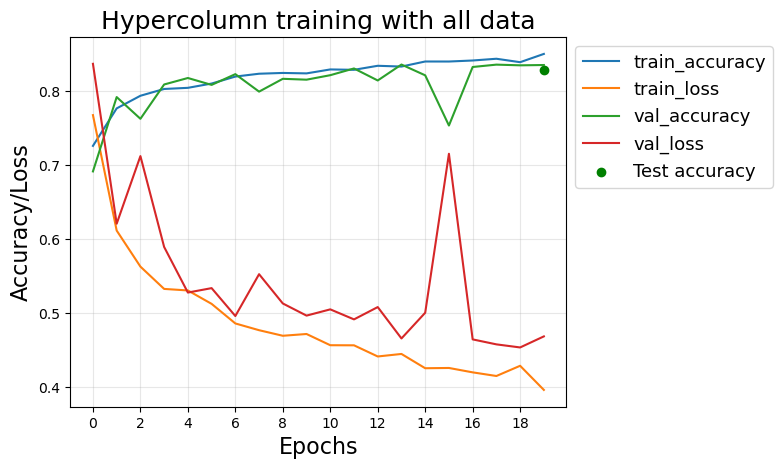

In [6]:
#Plot accuracies and losses
plottables = metrics
names = ["train_accuracy", "train_loss", "val_accuracy", "val_loss"]
from_epoch = 0
epoch_indices = range(len(plottables[0]))

#Plot all lines
for i in range(len(plottables)):
    plt.plot(epoch_indices[from_epoch:], plottables[i][from_epoch:], label=names[i])

#Plot test accuracy and iou
plt.scatter(len(epoch_indices)-1,  0.829, marker='o', color="green", label=f"Test accuracy")

plt.xticks(range(from_epoch, len(plottables[0]), 2))
plt.grid(alpha=0.3)
    
#Lables
plt.title("Hypercolumn training with all data", fontsize=18)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Accuracy/Loss", fontsize=16)
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1), fontsize=13)
plt.savefig("plots/Bestmodel_training", bbox_inches='tight')
plt.plot()